# Training Analysis (M1)

Given an output folder produced by `execute_m1.py`, this notebook will do 
the following: 
 - [x] Load the log files, parse the losses over time. 
 - [ ] Load the dataset with the proper parameters. 
	 - Use `data_format_args.pkl`.
 - [ ] Load the model from a particular checkpoint. 
	 - Use `instantiation_params.pkl`.
 - [ ] Run the model on some data, visualize the reconstructions it makes at each point in time. 
	 - Use `predictive_training_kwargs.pkl`.


In [1]:
## Which experiment do we want to analyze?
experiment_dir = "../training/debug/2022-10-28_04:37:48"

In [2]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math
import pickle

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

2022-11-01 23:05:34.022576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 23:05:34.152833: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-01 23:05:34.177545: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 23:05:34.678794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Loss Visualization over Time

In [3]:
# Get the stdout.log file, line by line. 
present_losses = []
future_losses = []
losses = []

stdo = open(os.path.join(experiment_dir, 'stdout.log'), 'r')

cnt = 0
for line in tqdm(stdo.readlines()):
	if line.startswith("Final loss:  "):
		loss_string = line.split(' ')[-1]
		loss = float(loss_string)
		losses.append(loss)
	elif line.startswith("Total surprise:"):
		loss_string = line.split(' ')[-1]
		present_loss = float(loss_string)
		present_losses.append(present_loss)
	elif line.startswith("Total future loss"):
		loss_string = line.split(' ')[-1]
		future_loss = float(loss_string)
		future_losses.append(future_loss)

present_losses = np.array(present_losses)
future_losses = np.array(future_losses)
losses = np.array(losses)


100%|██████████| 13584/13584 [00:00<00:00, 549579.20it/s]


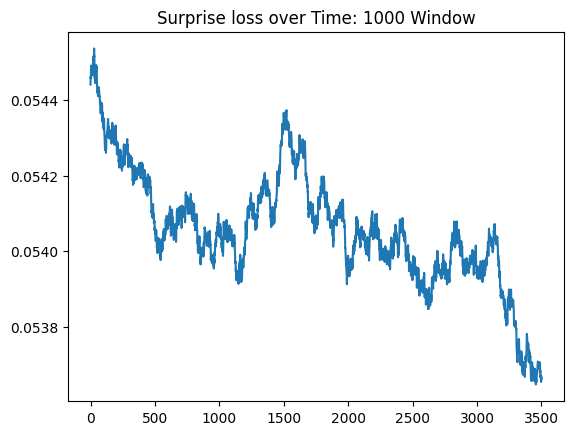

In [4]:
# plotting losses
def get_rolling_avg(ary_in, window=100):
	average_data = []
	for i in range(len(ary_in) - window + 1):
		average_data.append(np.mean(ary_in[i:i+window]))
	return np.array(average_data)

window_size=1000

plt.plot(get_rolling_avg(losses, window=window_size));
plt.title(f"Surprise loss over Time: {window_size} Window");

## Loading the Dataset

Formatting instructions found in `experiment_dir/data_format_args.pkl`.

In [5]:
# Read the pickle file
with open(os.path.join(experiment_dir, "data_format_args.pkl"), 'rb') as f: 
	data_format_args = pickle.load(f)

data_format_args

{'k_space': 15,
 'mu_space': 20,
 'k_time': 64,
 'mu_time': 200,
 'out_size': ['64', '64'],
 'patch_height': 4,
 'patch_width': 4,
 'patch_duration': 3}

In [6]:
k_space = data_format_args['k_space']
mu_space = data_format_args['mu_space']
k_time = data_format_args['k_time']
mu_time = data_format_args['mu_time']

out_size = [int(i) for i in data_format_args['out_size']]

patch_height = data_format_args['patch_height']
patch_width = data_format_args['patch_width']
patch_duration = data_format_args['patch_duration']

code_dim = 2*(2*k_space+1) + (2*k_time+1) # k_space = 15 and k_time = 64 -> 191

In [7]:
## Acquiring the dataset!
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp

# Meta/constants -- TODO: These should be commandline arguments. 
DATA_FOLDER = "../datasets/downloads"
num_frames = 100
output_size = out_size

# patch_height = 16
# patch_width = 16
# patch_duration = 3

batch_size = 1
num_prefetch = 4

# Fourier feature codes 
# k_space = 15
# mu_space = 20 
# k_time = 64 
# mu_time = 200

# Mp4 list: 
mp4_list = os.listdir(DATA_FOLDER)

## Acquiring the dataset!
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp

# Meta/constants -- TODO: These should be commandline arguments. 
DATA_FOLDER = "../datasets/downloads"
num_frames = 100
output_size = out_size

# patch_height = 16
# patch_width = 16
# patch_duration = 3

batch_size = 13
num_prefetch = 4

# Fourier feature codes 
# k_space = 15
# mu_space = 20 
# k_time = 64 
# mu_time = 200

# Mp4 list: 
mp4_list = os.listdir(DATA_FOLDER)

print("\n\n\n")
print("\t=========================")
print("\t=== DATASET META INFO ===")
print("\t=========================")
print("num_frames: ", num_frames)
print("batch_size: ", batch_size)
print("output_size: ", output_size)
print("Patch h/w/d: ", patch_height, patch_width, patch_duration)
print("k, mu for space, time: ", (k_space, mu_space), (k_time, mu_time))
print("mp4_list[:10] -- ", mp4_list[:10])


## Creating the generator
print("\n\n\n")
print("\t========================")
print("\t=== DATASET CREATION ===")
print("\t========================")
def generate_video_tensors():
	""" This is a generator for raw video tensors of shape 
	[num_frames, height, width, channels]. 

	It uses global variables defined above under "meta/constants". These 
	will be commandline arguments in the future. 
	"""
	_mp4_list = mp4_list
	_DATA_FOLDER = DATA_FOLDER
	_output_size = output_size
	_num_frames = num_frames
	while True: 
		for fname in _mp4_list:
			try:
				retval = vl.get_single_video_tensor(os.path.join(_DATA_FOLDER, fname), _num_frames, output_size=_output_size)
			except:
				continue
			if type(retval) == np.ndarray and retval.shape[0] == _num_frames:
				yield np.expand_dims(retval, axis=0)

videoset = tf.data.Dataset.from_generator(generate_video_tensors, output_signature=tf.TensorSpec(shape=[1, num_frames, *output_size, 3], dtype=tf.float32))
print(videoset)

def show_nn_sq(video_tensor, n=3, outname="breh.png"):
	n2 = n*n
	fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True)

	_nframes = video_tensor.shape[0]
	frame_inc = _nframes//(n2)

	for i in range(n):
		for j in range(n):
			full_idx = i*n + j

			axs[i,j].imshow(video_tensor[frame_inc*full_idx,:,:,:])
			axs[i,j].set_title(f"Frame {frame_inc*full_idx}")

	fig.suptitle(f"Video Survey over {_nframes} Frames")
	plt.savefig(outname)
	plt.show()

"""
out_test = "debug/test_from_videoset.png"
print(f"Showing off an element of the videodataset(generator) in `{out_test}`")	
for element in videoset:
	show_nn_sq(tf.squeeze(element), outname=out_test)
	break
"""

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(videoset, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=1)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=1)
FlatCodedPatchedSet = FlatCodedPatchedSet.map(lambda x: tf.squeeze(x))
FlatCodedPatchedSet = FlatCodedPatchedSet.batch(batch_size)
FlatCodedPatchedSet = FlatCodedPatchedSet.prefetch(num_prefetch)

cnt = 0
for el in FlatCodedPatchedSet: 
	print(" ** Shape of FlatCodedPatchedSet element: ", el.shape)
	cnt += 1
	if cnt == 2:
		break

print("Done getting datasets setup!")





	=== DATASET META INFO ===
num_frames:  100
batch_size:  13
output_size:  [64, 64]
Patch h/w/d:  4 4 3
k, mu for space, time:  (15, 20) (64, 200)
mp4_list[:10] --  ['H1iWETEMl7c.mp4', 'PmKbAgKa_V8.mp4', 'zymMiwUtbqE.mp4', 'jpeB76IUI9c.mp4', '5d-u6-UzbLk.mp4', 'm-EUUkPuocE.mp4', '_LUKHNsSndk.mp4', 'xp5sV_1SSKw.mp4', 'JXtr3GbDYHY.mp4', '3SeOIr2YisM.mp4']




	=== DATASET CREATION ===
<FlatMapDataset element_spec=TensorSpec(shape=(1, 100, 64, 64, 3), dtype=tf.float32, name=None)>
Making patches from Videoset...


2022-11-01 23:05:39.553649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 23:05:40.666745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-11-01 23:05:40.667493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:68:00.0, compute capability: 8.6


Making the flat patch set...
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
 ** Shape of FlatCodedPatchedSet element:  (13, 8448, 335)
 ** Shape of FlatCodedPatchedSet element:  (13, 8448, 335)
Done getting datasets setup!


In [8]:
## Visualizing a dataset element: 

## Instantiating the Model

In [9]:
import m1

In [10]:
# Read the pickle file
with open(os.path.join(experiment_dir, "instantiation_params.pkl"), 'rb') as f: 
	instantiation_params = pickle.load(f)

instantiation_params

{'encoder_args': [1],
 'encoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'latent_ev_args': [1],
 'latent_ev_kwargs': {'distinct_blocks': False,
  'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'decoder_args': [144, 1, 0],
 'decoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'perceiver_kwargs': {'code_dim': 191,
  'latent_dims': [700, 100],
  'p_droptoken': 0.5}}

In [11]:
## Setting up the component modules of the top-level PAE model.
# Encoder 

# Getting arguments 
encoder_args = instantiation_params['encoder_args']
encoder_kwargs = instantiation_params['encoder_kwargs']

test_encoder = m1.PAE_Encoder(*encoder_args, **encoder_kwargs)

# Latent evolver 
latent_ev_args = instantiation_params['latent_ev_args']
latent_ev_kwargs = instantiation_params['latent_ev_kwargs']

test_latent_ev = m1.PAE_Latent_Evolver(*latent_ev_args,**latent_ev_kwargs) 


# decoder
decoder_args = instantiation_params['decoder_args']
decoder_kwargs = instantiation_params['decoder_kwargs']

test_decoder = m1.PAE_Decoder(*decoder_args, **decoder_kwargs)

# Loss function definition
mse = tf.keras.losses.MeanSquaredError()

## Instantiating the PAE model!
perceiver_kwargs = instantiation_params['perceiver_kwargs']

perceiver_ae = m1.PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, **perceiver_kwargs)

In [12]:
# Loading parameters!
checkpoint_dir = "../training/debug/2022-10-27_01:12:56/"
checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
latest = tf.train.latest_checkpoint(checkpoint_dir)
print("Latest checkpoint: ", latest)
perceiver_ae.load_weights(latest)

Latest checkpoint:  ../training/debug/2022-10-28_04:37:48/checkpoints/cp-4400.ckpt


## Getting Training Parameters

In [13]:
# Read the pickle file
with open(os.path.join(experiment_dir, "predictive_training_kwargs.pkl"), 'rb') as f: 
	training_kwargs = pickle.load(f)

training_kwargs

{'alpha': 0.7,
 'blind_iters': 1,
 'present_time_window': 5,
 'prediction_time_window': 30,
 'prob_prediction_select': 0.1,
 'window_increment': 5}

# Running the "Training loop"

In [14]:
perceiver_ae

In [15]:
training_kwargs
alpha = training_kwargs['alpha']
blind_iters = training_kwargs['blind_iters']
present_time_window = training_kwargs['present_time_window']
prediction_time_window = training_kwargs['prediction_time_window']
prob_prediction_select = training_kwargs['prob_prediction_select']
window_increment = training_kwargs['window_increment']

In [16]:
# get a batch tensor. 
batch_tensor = None
for ele in FlatCodedPatchedSet: 
	batch_tensor = ele 
	break

batch_tensor.shape

TensorShape([13, 8448, 335])

Text(0.5, 1.0, 'Video Tokens')

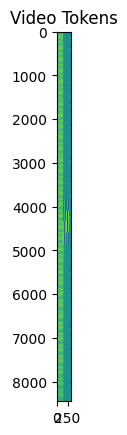

In [17]:
# Visualize the batch tensor
plt.imshow(batch_tensor[0,:,:])
plt.title("Video Tokens")

In [18]:
# Reconstruct the original
def get_source_video(flatpatched_coded):

	n_time_patches = num_frames // patch_duration
	n_height_patches = output_size[0] // patch_height 
	n_width_patches = output_size[1] // patch_width 

	x = flatpatched_coded

	x_patch = vp.unflatten_patched(x, n_time_patches, n_height_patches, n_width_patches)
	print("x_patch shape: ", x_patch.shape)
	print("p_dur, p_height, p_width: ", patch_duration, patch_height, patch_width)
	x_3dpatch = vp.make_3D_patches(x_patch, patch_duration, patch_height, patch_width)
	x_video = vp.get_vidtensor_from_8D(x_3dpatch)

	return x_video

source_vid = get_source_video(batch_tensor[:,:,:-code_dim])
source_vid.shape

x_patch shape:  (13, 33, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 99, 64, 64, 3])

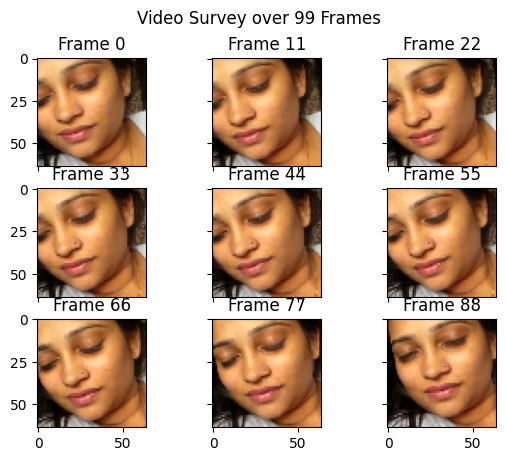

In [19]:
for i in range(source_vid.shape[0]):
	show_nn_sq(source_vid[i,:,:,:,:])
	break

In [20]:
assert 0 <= alpha

num_width = output_size[1] // patch_width
num_height = output_size[0] // patch_height
tokens_per_frame = (num_width * num_height)/patch_duration

num_tokens = batch_tensor.shape[1]

num_frames = round(num_tokens/tokens_per_frame)
window_inc_tokens = window_increment * tokens_per_frame
num_iters = round(num_tokens/window_inc_tokens)

window_inc_tokens = window_inc_tokens

present_window_tokens = round(present_time_window * tokens_per_frame)
future_window_tokens = round(prediction_time_window * tokens_per_frame)

"""
print("\nNUM TOKENS: ", num_tokens)
print("NUM FRAMES: ", num_frames)

print("Window increment (frames): ", window_increment)
print("Window increment (tokens): ", window_inc_tokens)

print("NUM ITERS: ", num_iters)
print("Future window tokens (pre-mask): ", future_window_tokens)
"""

future_msk = np.zeros(future_window_tokens, dtype=np.bool)
future_msk[:round(future_window_tokens*prob_prediction_select)] = True
np.random.shuffle(future_msk)

surprise_loss = 0.0 	# Corresponds to prediction of incoming data from the "present"
future_loss = 0.0		# Corresponds to prediction loss on far future data. 
loss = 0.0

for i in range(num_iters):
	# Calculating the present window.
	present_window_end = i*window_inc_tokens + present_window_tokens 
	present_window_end = round(present_window_end)
	if present_window_end > num_tokens:
		present_window_end = num_tokens
	window_start = present_window_end - present_window_tokens

	# Calculating the future window.
	future_window_end = window_start + future_window_tokens
	if future_window_end > num_tokens:
		future_window_end = num_tokens

	future_window_start = future_window_end - future_window_tokens
	# print(f"Iteration {i} of {num_iters}")
	# print(f"\tPRESENT WINDOW: [{window_start}, {present_window_end}] -- \t{present_window_end-window_start}")
	# print(f"\tFUTURE WINDOW: [{future_window_start}, {future_window_end}] -- \t{future_window_end - future_window_start}")

	## Extracting current windowed tensors 
	present = batch_tensor[:,window_start:present_window_end,:]
	future_ = batch_tensor[:,future_window_start:future_window_end,:]
	future = tf.boolean_mask(future_, future_msk, axis=1)

	np.random.shuffle(future_msk)

	# print("\tPresent Tensor Shape: ", present.shape)
	# print("\tFuture  Tensor Shape: ", future.shape)

	reset = i==0
	# pdb.set_trace()
	cur_surprise = perceiver_ae(present, reset_latent=reset)
	fut_surprise = perceiver_ae(future, remember_this=False, no_droptoken=True)
	print("PRESENT SURPRISE: ", cur_surprise.numpy())
	if i >= blind_iters:
		surprise_loss += cur_surprise
		future_loss += fut_surprise		

	# print(f"\tCurrent loss: ", cur_surprise.numpy())
	# print(f"\tFuture loss: ", fut_surprise.numpy())

surprise_loss /= (num_iters-blind_iters)
future_loss /= (num_iters-blind_iters)

loss = alpha*surprise_loss + (1-alpha)*future_loss


print("Total surprise: ", surprise_loss.numpy())
print("Total future loss: ", future_loss.numpy())

print("Final loss: ", loss.numpy())

/tmp/ipykernel_1139222/3053581489.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  future_msk = np.zeros(future_window_tokens, dtype=np.bool)
2022-11-01 23:06:13.448802: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-01 23:06:13.965797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


PRESENT SURPRISE:  1.2883078
PRESENT SURPRISE:  0.052434806
PRESENT SURPRISE:  0.048207846
PRESENT SURPRISE:  0.048031904
PRESENT SURPRISE:  0.046678334
PRESENT SURPRISE:  0.050292797
PRESENT SURPRISE:  0.048185512
PRESENT SURPRISE:  0.04916542
PRESENT SURPRISE:  0.048337936
PRESENT SURPRISE:  0.04662755
PRESENT SURPRISE:  0.04870985
PRESENT SURPRISE:  0.04972772
PRESENT SURPRISE:  0.04771899
PRESENT SURPRISE:  0.046534058
PRESENT SURPRISE:  0.047851484
PRESENT SURPRISE:  0.045276687
PRESENT SURPRISE:  0.044914063
PRESENT SURPRISE:  0.04736009
PRESENT SURPRISE:  0.0474298
PRESENT SURPRISE:  0.046605673
Total surprise:  0.0478995
Total future loss:  0.047682274
Final loss:  0.047834333


## Failed Attempt to Reconstruct the ENTIRE Tensor

Since the tokens being decoded change eachother's values via the self-attention
mechanism, we can't deviate too far from the decoding style of training.  

Even though we had loss ~= 0.03 when re-running the training loop, we have 
terrible performance when reconstructing the entire tensor at once. 


In [21]:
# Let's try reconstructing the video: 
reconstruct_me_codes = batch_tensor[:,:,-code_dim:]
reconstruct_me_codes.shape

TensorShape([13, 8448, 191])

In [22]:
reconstruction = perceiver_ae.decoder([reconstruct_me_codes, perceiver_ae.latent])

In [31]:
print("Reconstruction shape: ", reconstruction.shape)
print("Batch tensor shape: ", batch_tensor[:,:,].shape)

Reconstruction shape:  (13, 8448, 144)
Batch tensor shape:  (13, 8448, 335)


In [32]:
tf.keras.losses.MeanSquaredError()(reconstruction, batch_tensor[:,:,:-code_dim])

<tf.Tensor: shape=(), dtype=float32, numpy=0.049013235>

In [25]:
source_vid = get_source_video(reconstruction)
source_vid.shape

x_patch shape:  (13, 33, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 99, 64, 64, 3])

In [37]:
truth_vid = get_source_video(batch_tensor[:,:,:-code_dim])
truth_vid.shape

x_patch shape:  (13, 33, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 99, 64, 64, 3])

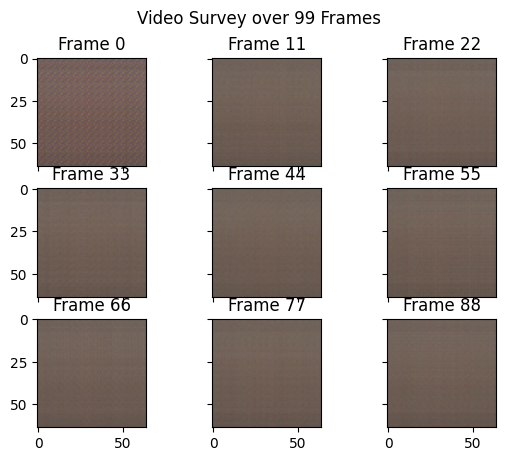

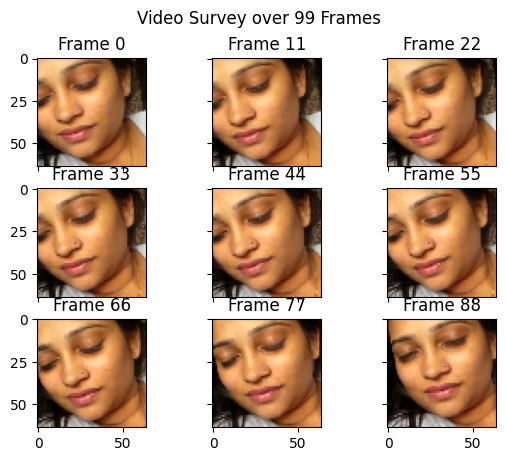

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.06334784


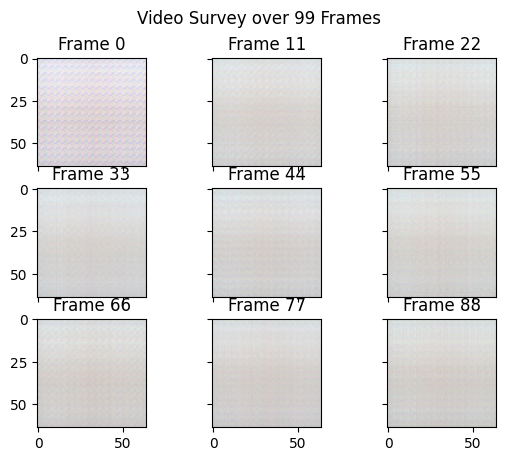

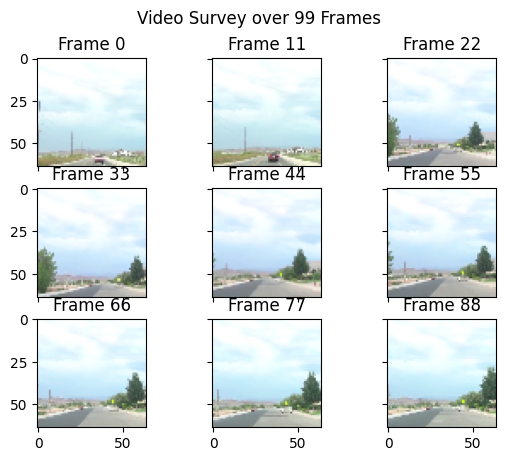

0.02925973


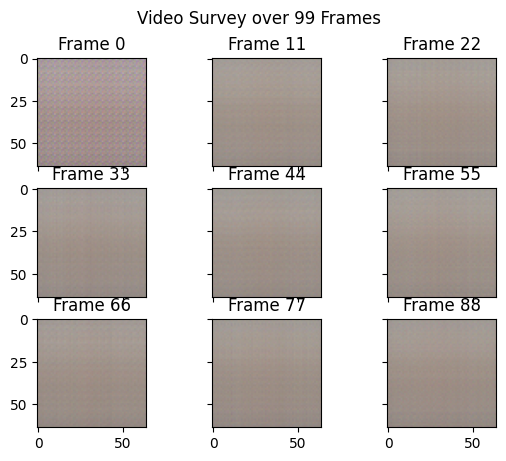

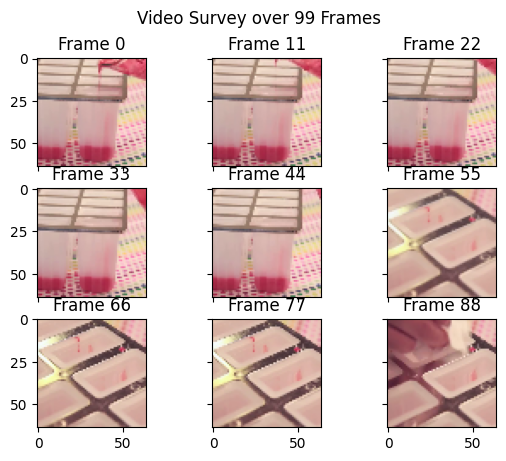

0.035364773


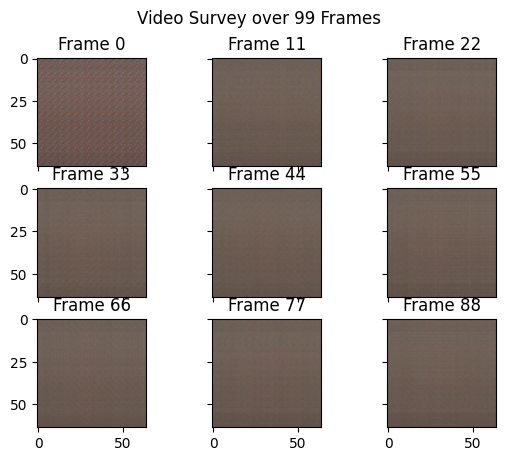

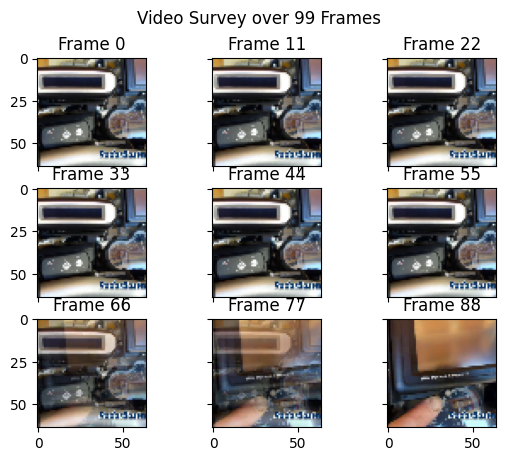

0.07383308


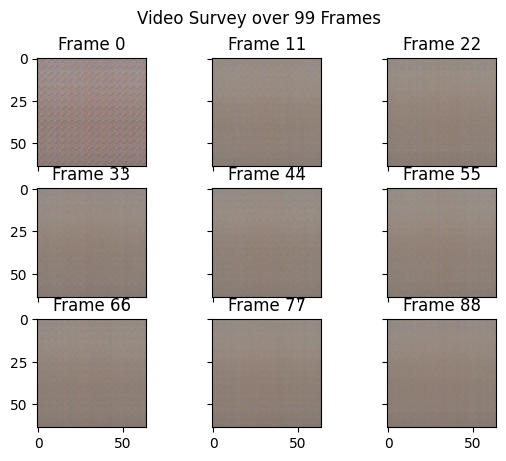

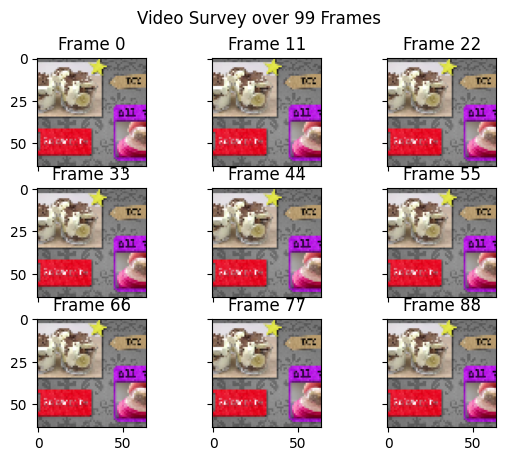

0.048364762


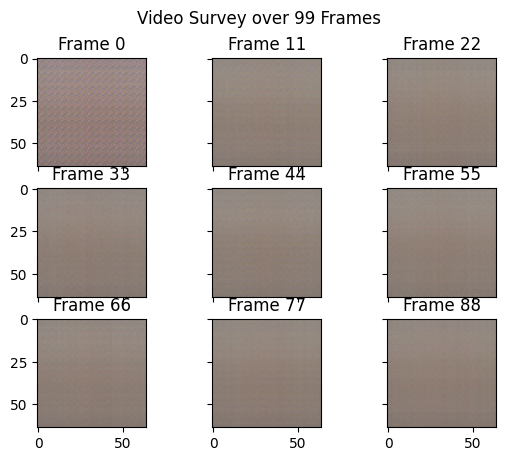

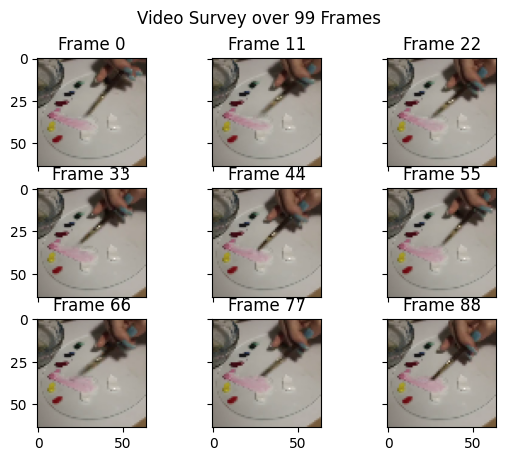

0.035606354


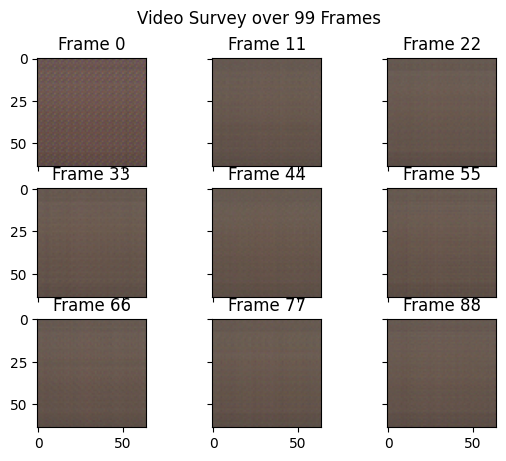

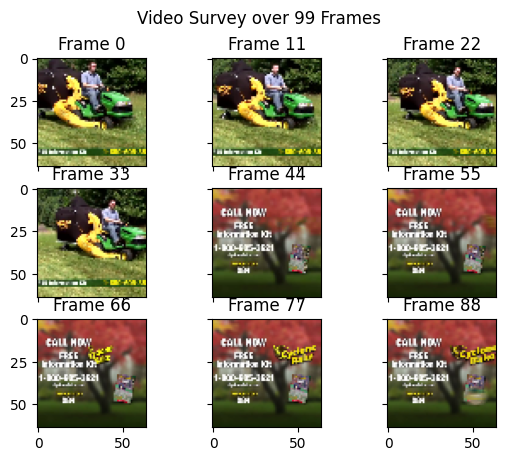

0.059587568


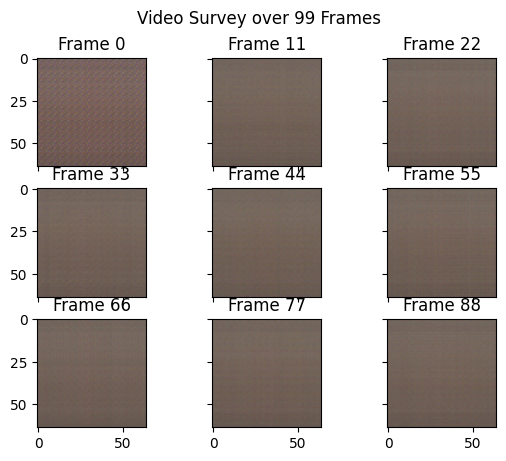

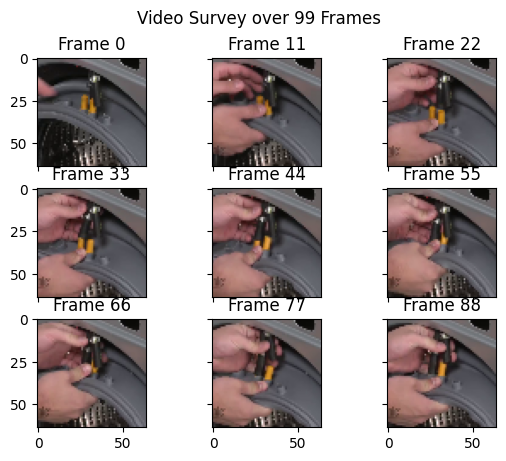

0.026262434


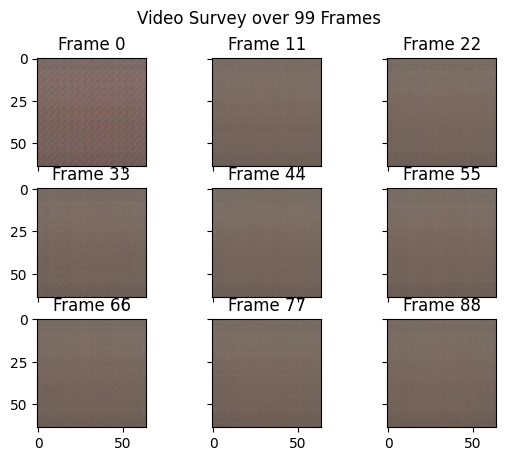

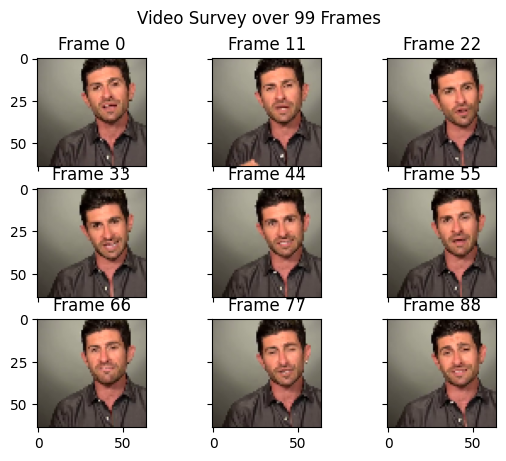

0.032601528


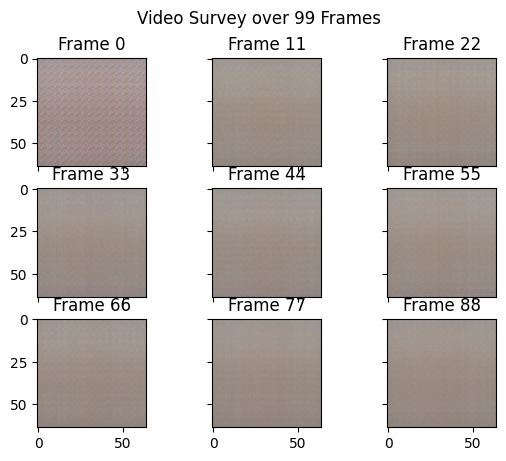

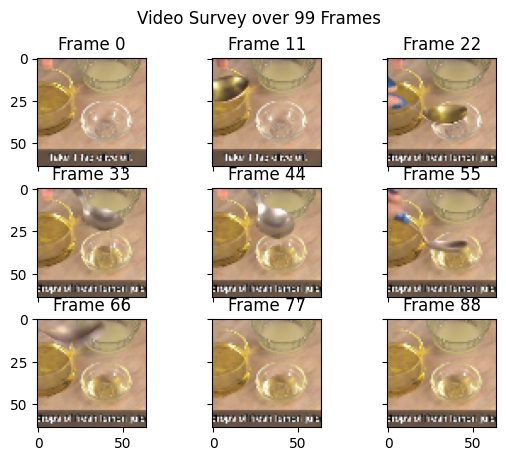

0.026221426


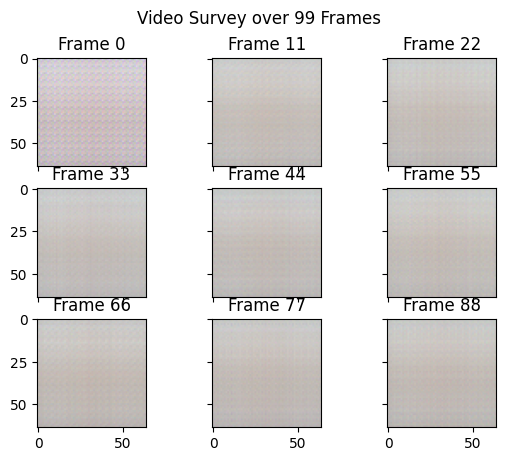

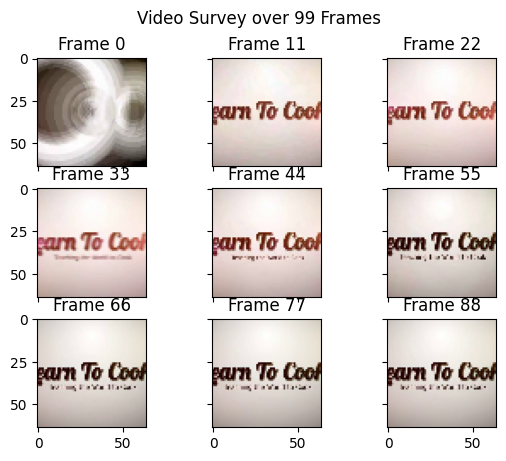

0.042092927


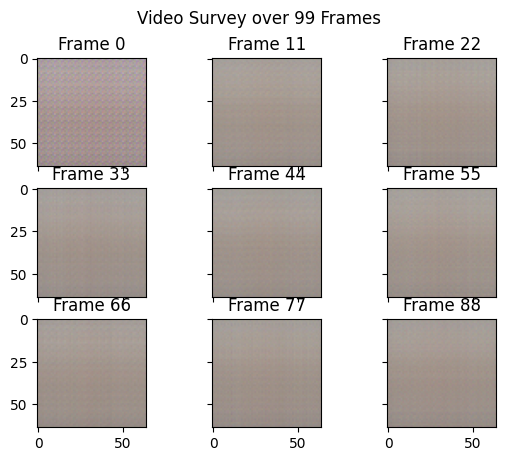

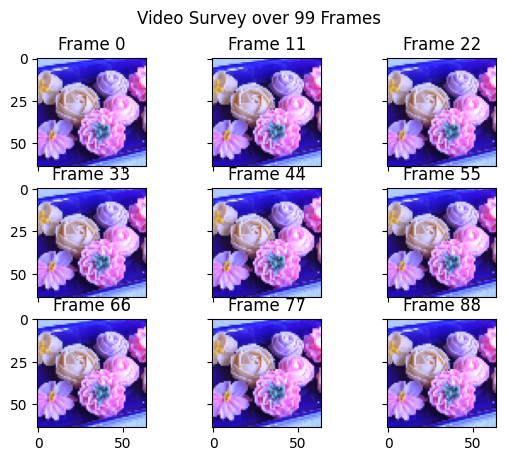

0.1074654


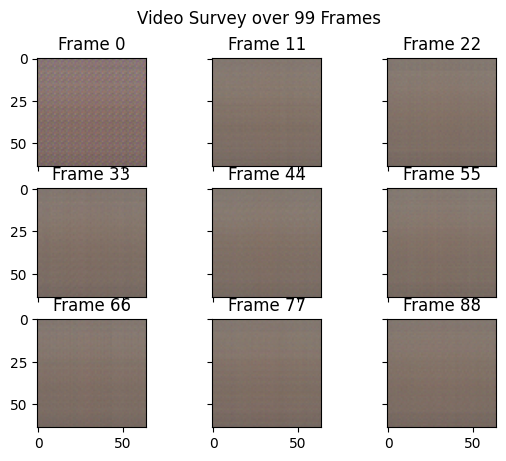

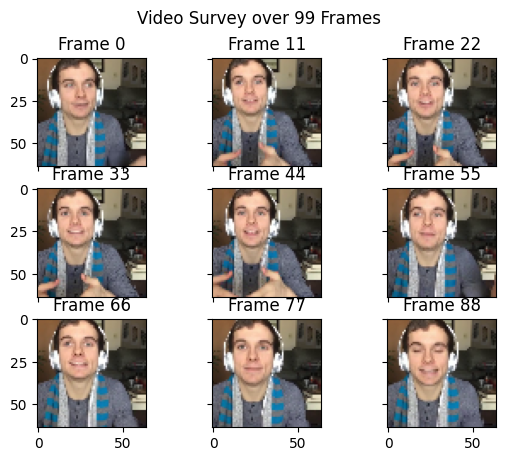

0.05716425
AVERAGE LOSS:  tf.Tensor(0.04901324, shape=(), dtype=float32)


: 

In [38]:
full_reconstruction_losses = 0.0
for i in range(source_vid.shape[0]):
	show_nn_sq(source_vid[i,:,:,:,:])
	show_nn_sq(truth_vid[i,:,:,:,:])
	loss = tf.keras.losses.MeanSquaredError()(reconstruction[i,:,:], batch_tensor[i,:,:-code_dim])
	print(loss.numpy())
	full_reconstruction_losses += loss/source_vid.shape[0]
print("AVERAGE LOSS: ", full_reconstruction_losses)

In [27]:
batch_tensor.shape

TensorShape([13, 8448, 335])

In [28]:
source_vid.shape

TensorShape([13, 99, 64, 64, 3])

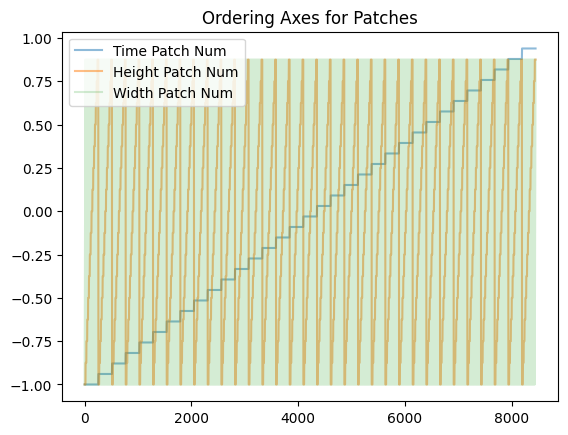

In [29]:
plt.plot(batch_tensor[0, :, -code_dim + k_time*2], label='Time Patch Num',alpha=0.5)
plt.plot(batch_tensor[0, :, -code_dim + (2*k_time+1)+(2*k_space)], label='Height Patch Num', alpha=0.5)
plt.plot(batch_tensor[0, :, -code_dim + (2*k_time+1)+(2*k_space+1)+(2*k_space)], label='Width Patch Num', alpha=0.2)
plt.title("Ordering Axes for Patches")
plt.legend()


In [113]:
# Trying to decode just one frame.
patches_per_patch_dur = num_height * num_width
patches_per_patch_dur

256

In [117]:
patch_dur_num = 72//3
start_patch = (patch_dur_num-1)*patches_per_patch_dur
end_patch = (patch_dur_num)*patches_per_patch_dur

print(f"Start: {start_patch}, end: {end_patch}")

Start: 5888, end: 6144


In [118]:
batch_tensor.shape

TensorShape([13, 8448, 335])

In [119]:
codes_specific = batch_tensor[:,start_patch:end_patch,-code_dim:]
codes_specific.shape

TensorShape([13, 256, 191])

In [120]:
reconstruction = perceiver_ae.decoder([codes_specific, perceiver_ae.latent])
reconstruction.shape

TensorShape([13, 256, 144])

In [123]:
patch_duration

3

In [127]:
# Reconstruct the original
def get_source_video(flatpatched_coded, num_frames, output_size, patch_hwd=(4,4,3)):
	patch_height, patch_width, patch_duration = patch_hwd

	n_time_patches = num_frames // patch_duration
	n_height_patches = output_size[0] // patch_height 
	n_width_patches = output_size[1] // patch_width 

	print(n_time_patches, n_height_patches, n_width_patches)
	x = flatpatched_coded

	x_patch = vp.unflatten_patched(x, n_time_patches, n_height_patches, n_width_patches)
	print("x_patch shape: ", x_patch.shape)
	print("p_dur, p_height, p_width: ", patch_duration, patch_height, patch_width)
	x_3dpatch = vp.make_3D_patches(x_patch, patch_duration, patch_height, patch_width)
	x_video = vp.get_vidtensor_from_8D(x_3dpatch)

	return x_video


num_frames = patch_duration
print("num_frames: ", num_frames)
patch_hwd = (patch_height, patch_width, patch_duration)
reconstructed_vid = get_source_video(reconstruction, num_frames, output_size, patch_hwd = patch_hwd)
reconstructed_vid.shape

num_frames:  3
1 16 16
x_patch shape:  (13, 1, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 3, 64, 64, 3])

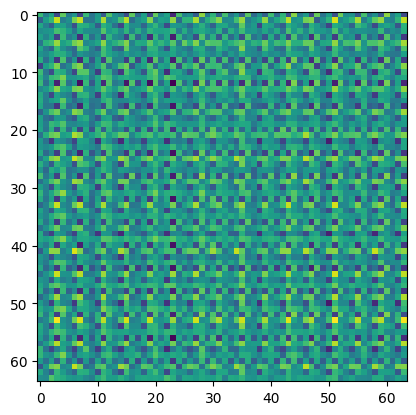

In [130]:
plt.imshow(reconstructed_vid[0,0,:,:,:])

## Decoding a smaller number of patches

Let's try mimicking the requests made in training: Let's try decoding 50% of the 
pixels from the `present` time window. 

In [22]:
present_window_tokens
batch_tensor.shape
final_present_tensor = batch_tensor[:,-present_window_tokens:, :]
final_present_tensor.shape


TensorShape([13, 427, 335])

In [30]:
code_query = final_present_tensor[:,:,-code_dim:]
print("Query shape: ", code_query.shape)
reconstruction = perceiver_ae.decoder([final_present_tensor[:,:,-code_dim:], perceiver_ae.latent])

Query shape:  (13, 427, 191)


In [31]:
reconstruction.shape

TensorShape([13, 427, 144])

In [33]:
## Reshaping the reconstruction
# Reconstruct the original
def get_source_video(flatpatched_coded, num_frames, output_size, patch_hwd=(4,4,3)):
	patch_height, patch_width, patch_duration = patch_hwd

	n_time_patches = num_frames // patch_duration
	n_height_patches = output_size[0] // patch_height 
	n_width_patches = output_size[1] // patch_width 

	print(n_time_patches, n_height_patches, n_width_patches)
	x = flatpatched_coded

	x_patch = vp.unflatten_patched(x, n_time_patches, n_height_patches, n_width_patches)
	print("x_patch shape: ", x_patch.shape)
	print("p_dur, p_height, p_width: ", patch_duration, patch_height, patch_width)
	x_3dpatch = vp.make_3D_patches(x_patch, patch_duration, patch_height, patch_width)
	x_video = vp.get_vidtensor_from_8D(x_3dpatch)

	return x_video


# num_frames = present_time_window 
num_frames = 3
print("num_frames: ", num_frames)
patch_hwd = (patch_height, patch_width, patch_duration)
reconstructed_vid = get_source_video(reconstruction[:,:256,:], num_frames, output_size, patch_hwd = patch_hwd)
reconstructed_vid.shape

num_frames:  3
1 16 16
x_patch shape:  (13, 1, 16, 16, 144)
p_dur, p_height, p_width:  3 4 4


TensorShape([13, 3, 64, 64, 3])

In [39]:
# Calculate loss
mse(final_present_tensor[:,:,:-code_dim], reconstruction[:,:,:])

<tf.Tensor: shape=(), dtype=float32, numpy=0.57169753>

In [34]:
reconstructed_vid.shape

TensorShape([13, 3, 64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


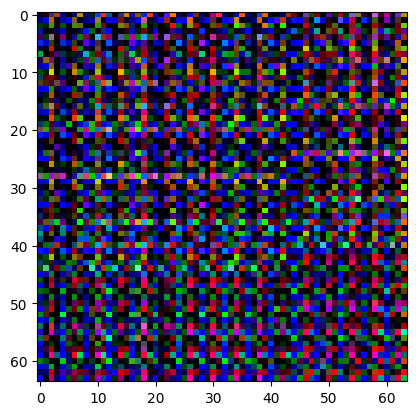

In [35]:
plt.imshow(reconstructed_vid[0,0,:,:,:])